In [1]:
from sklearn.metrics import roc_curve, precision_recall_curve
import pandas as pd
from matplotlib import pyplot as plt

In [90]:
g_colors = ['#8ecfc9', '#ffbe7a', '#fa7f6f', '#82b0d2']
g_callers = ['RabbitVar', 'Strelka2', 'Mutect2', 'VarDict']
g_color_map = {}
for ca, co in zip(g_callers, g_colors):
  g_color_map[ca] = co


In [2]:
def get_bed_sorted(bed):
  regions = dict()
  with open(bed, 'r') as f:
    for line in f:
      chr, start, end = line.split('\t')[:3]
      if str(chr) in regions:
        regions[str(chr)].append([int(start), int(end)])
      else:
        regions[str(chr)] = list()
        regions[str(chr)].append([int(start), int(end)])
  for k, v in regions.items():
    regions[k] = sorted(v)
  return regions

def is_in_highconf(chr, start, regions):
  if chr not in regions:
    return False
  regs = regions[chr]
  start = int(start)
  for rstart, rend in regs:
    if start + 50 < rstart:
      break
    if start > rstart and start < rend:
      #print('in region:', start, rstart, rend)
      return True
  return False

In [119]:
import gzip
import os
def haoz_get_f(fn):
  gziped = fn.endswith('.gz')
  if fn.find(':') != -1:
    print('geting remote file', f'scp {fn} /dev/shm/tmp.gz')
    if gziped:
      ret = os.system(f'scp {fn} /dev/shm/tmp.gz')
      fn = "/dev/shm/tmp.gz"
    else:
      ret = os.system(f'scp {fn} /dev/shm/tmp.vcf')
      fn = "/dev/shm/tmp.vcf"
    print("status: ", ret)
    if ret != 0: return []

  if gziped:
    f = gzip.open(fn, 'rb')
    lines = [x.decode() for x in f.readlines()]
    f.close()
  else:
    f = open(fn, 'r')
    lines = f.readlines()
    f.close()
  return lines

def get_sk2_pred_socre(fn):
    site2socre = dict()
    #with open(fn, 'r') as f:
    f = haoz_get_f(fn)
    for line in f:
        if line.startswith('#'): continue
        CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR = line.split('\t')
        if vtype == "INDEL" and (len(REF) == 1 and len(ALT) == 1): continue
        elif vtype == "SNV" and (len(REF) > 1 or len(ALT) > 1): continue
        if FILTER.find("PASS") == -1: continue
        #if not is_in_highconf(CHROM, POS, highconf_regions): continue
        for tmp in INFO.split(';'):
            if tmp.startswith('SomaticEVS'):
                evs_score = tmp.strip()
        evs_score = evs_score.split('=')[-1].strip()
        evs_score = float(evs_score)
        site2socre[':'.join([CHROM, POS, REF, ALT])] = evs_score
    return site2socre

def get_rv_pred_score(fn):
    site2socre = dict()
    f = haoz_get_f(fn)
    for line in f:
      if line.startswith('#'): continue
      CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR = line.split('\t')
      for tmp in INFO.split(';'):
          if tmp.startswith('RFV'):
              evs_score = tmp.strip()
      evs_score = evs_score.split('=')[-1].strip()
      evs_score = float(evs_score)
      site2socre[':'.join([CHROM, POS, REF, ALT])] = evs_score
    return site2socre 

def get_mt_pred_socre(fn):
    site2score = dict()
    f = haoz_get_f(fn)
    #with open(fn, 'r') as f:
    for line in f:
      if line.startswith('#'): continue
      CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR = line.split('\t')
      if vtype == "INDEL" and (len(REF) == 1 and len(ALT) == 1): continue
      elif vtype == "SNV" and (len(REF) > 1 or len(ALT) > 1): continue
      if FILTER.find("PASS") == -1: continue
      #if not is_in_highconf(CHROM, POS, highconf_regions): continue
      many_alt = True if ALT.find(',') != -1 else False
      for tmp in INFO.split(';'):
          if tmp.startswith('TLOD'):
            evs_scores = tmp.strip().split('=')[-1].strip()
            evs_scores = [x.strip() for x in evs_scores.split(',')]
      for alt, evs_score in zip(ALT.split(','), evs_scores):
        evs_score = float(evs_score)
        site2score[':'.join([CHROM, POS, REF, alt])] = evs_score
        #print(':'.join([CHROM, POS, REF, alt]), evs_score)
    return site2score

def get_vd_pred_score(fn):
    site2socre = dict()
    f = haoz_get_f(fn)
    #with open(fn, 'r') as f:
    for line in f:
        if line.startswith('#'): continue
        CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR = line.split('\t')
        if vtype == "INDEL" and (len(REF) == 1 and len(ALT) == 1): continue
        elif vtype == "SNV" and (len(REF) > 1 or len(ALT) > 1): continue
        if FILTER.find("PASS") == -1: continue
        for tmp in INFO.split(';'):
            if tmp.startswith('SSF'):
                evs_score = tmp.strip()
        evs_score = evs_score.split('=')[-1].strip()
        evs_score = float(evs_score)
        site2socre[':'.join([CHROM, POS, REF, ALT])] = evs_score
    return site2socre 

def plot_prec_recall_curve(tmp, label):
    data = pd.DataFrame()
    data['site'] = tmp.keys()
    data['pred'] = tmp.values()
    data['truth'] = data.apply(rabv_get_label, axis = 1)
    precision, recall, thresholds = precision_recall_curve(data['truth'], data['pred'])
    plt.plot(recall, precision, label = label, color = g_color_map[label], linewidth = 3)  
    if g_add_legend:
      plt.legend()

In [7]:
import  multiprocessing 

def get_mt_pred_score_from_list(datalines):
  site2score = dict()
  for line in datalines:
    if line.startswith('#'): continue
    CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR = line.split('\t')
    if vtype == "INDEL" and (len(REF) == 1 and len(ALT) == 1): continue
    elif vtype == "SNV" and (len(REF) > 1 or len(ALT) > 1): continue
    if not is_in_highconf(CHROM, POS, highconf_regions): continue
    many_alt = True if ALT.find(',') != -1 else False
    for tmp in INFO.split(';'):
      if tmp.startswith('TLOD'):
        evs_scores = tmp.strip().split('=')[-1].strip()
        evs_scores = [x.strip() for x in evs_scores.split(',')]
    for alt, evs_score in zip(ALT.split(','), evs_scores):
      evs_score = float(evs_score)
      site2score[':'.join([CHROM, POS, REF, alt])] = evs_score
      #print(':'.join([CHROM, POS, REF, alt]), evs_score)
    return site2score

def get_pred_score_parallel(fn, th_nums):
  site2score = dict()
  task_lines = []
  with open(fn, 'r') as f:
    tmplist = f.readlines()
    stride = len(tmplist) // th_nums
    for i in range(th_nums-1):
      task_lines.append(tmplist[i*stride:(i+1)*stride])
    task_lines.append(tmplist[(th_nums - 1)*stride:])
  ps = []
  results = list()
  cite2scores = dict()
  with multiprocessing.Pool(th_nums) as pool:
    result = dict()
    #multiprocessing.Pool(8)
    results = [pool.apply_async(get_mt_pred_score_from_list, lines) for lines in task_lines]
    for r in results:
      cite2scores = cite2scores | r.get()
  return sorted(cite2scores)
    
vtype = 'INDEL'
tmp_mt2 = get_pred_score_parallel("./WGS_NV_T_1-mutect2.vcf", 8)
#tmp1 = get_rv_pred_score("./indel.vcf")
plot_prec_recall_curve(tmp_mt2, 'Mutect2')
#plot_prec_recall_curve(tmp1, 'RabbitVar')
  

Process SpawnPoolWorker-25:
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.9/3.9.5/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python@3.9/3.9.5/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python@3.9/3.9.5/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/local/Cellar/python@3.9/3.9.5/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'get_mt_pred_score_from_list' on <module '__main__' (built-in)>
Process SpawnPoolWorker-26:
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.9/3.9.5/Frameworks/Python.framework/Versi

KeyboardInterrupt: 

In [163]:
def get_truth(truth_file):
    truth_vars = set()
    with open(truth_file, 'r') as f:
        for var in f:
            if var[0] == '#': continue
            items = var.split('\t')
            chrom, pos, id, ref, alt, _, filter = items[:7]
            #if len(chrom) < 6 and filter == "PASS" and (len(ref) > 1 or len(alt) > 1) :
            if (filter.find('PASS') == -1) and (filter.strip() != '.') :
                #print('pass:', filter.strip())
                continue
            if len(chrom) < 6:
                site = chrom + ":" + pos + ":" + ref.upper() + ":" + alt.upper()
                truth_vars.add(site)
    return truth_vars

def get_label(truth_vars, key):
    if key in truth_vars:
        return 1
    else :
        return 0
    return 0

def rabv_get_label(x, truth_vars):
    return get_label(truth_vars, str(x['site']))


#-----construct strelka2 result------#
# tmp1 = get_rv_pred_score("/home/user_home/haoz/workspace/RabbitVar/RandomForest/validate/indel.vcf")
# plot_prec_recall_curve(tmp1)
# tmp2 = get_sk2_pred_socre("/home/large/haoz/data/bcbio_bench_result/octopus_sync_PACA/final_strelka2/OCT_NA24631_T/OCT_NA24631_T-strelka2.vcf")
# plot_prec_recall_curve(tmp2)
# plt.legend()
# plt.show()

In [5]:
highconf_regions = get_bed_sorted("/home/user_home/data_share/FD/Truth/High-Confidence_Regions_v1.2.bed")

## INDEL ROC CURVE

In [121]:
plt.rcParams["figure.figsize"] = (8, 10)
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["axes.labelsize"] = 20

length of truth vars is: 2069
geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_80x/HCC1395_SPP_PURE_80x/SPP_GT_1-0_1/SPP_GT_1-0_1-strelka2.vcf.gz /dev/shm/tmp.gz
status:  0
geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_80x/HCC1395_SPP_PURE_80x/SPP_GT_1-0_1/SPP_GT_1-0_1-mutect2.vcf.gz /dev/shm/tmp.gz
status:  0


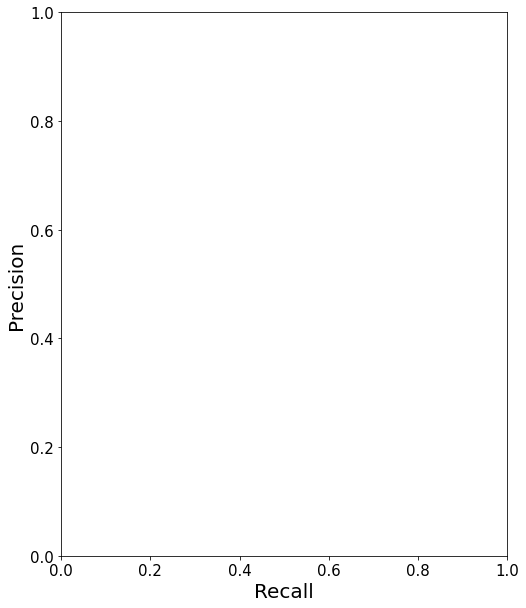

In [142]:
# ----------- INDEL ROC curve-------------#
truth_file = "/home/user_home/data_share/FD/Truth/sINDEL.MDKT.superSet.v1.2.vcf"
truth_vars = get_truth(truth_file)
print('length of truth vars is:', len(truth_vars))
vtype = "INDEL"   
ROC_DATA_INDEL = dict()

g_add_legend = False
plt.xlabel('Recall')
plt.ylabel('Precision')    
#tmp_vd = get_vd_pred_score("a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_80x/HCC1395_SPP_PURE_80x/SPP_GT_1-0_1/SPP_GT_1-0_1-vardict.vcf.gz")
tmp_rv = get_rv_pred_score("/home/large/haoz/HCC1395_DATAS/SPP/rabbitvar_result/diff_dpeth/som_res_0918/SPP_PURE_80x_withscore.indel.vcf")
tmp_sk = get_sk2_pred_socre("a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_80x/HCC1395_SPP_PURE_80x/SPP_GT_1-0_1/SPP_GT_1-0_1-strelka2.vcf.gz")
tmp_mt = get_mt_pred_socre("a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_80x/HCC1395_SPP_PURE_80x/SPP_GT_1-0_1/SPP_GT_1-0_1-mutect2.vcf.gz")
ROC_DATA_INDEL['80x'] = [tmp_rv, tmp_sk, tmp_mt]
# plot_prec_recall_curve(tmp1, 'RabbitVar')
# plot_prec_recall_curve(tmp2, 'Strelka2')
# plot_prec_recall_curve(tmp_mt2, 'Mutect2')
#plot_prec_recall_curve(tmp_vd, 'VarDict')
#plt.show()
#plt.savefig('80xindel.roc.pdf', format = "PDF")

geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_10x/HCC1395_SPP_PURE_10x/SPP_GT_1-0_1//SPP_GT_1-0_1-strelka2.vcf.gz /dev/shm/tmp.gz
status:  0
geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_10x/HCC1395_SPP_PURE_10x/SPP_GT_1-0_1//SPP_GT_1-0_1-mutect2.vcf.gz /dev/shm/tmp.gz
status:  0


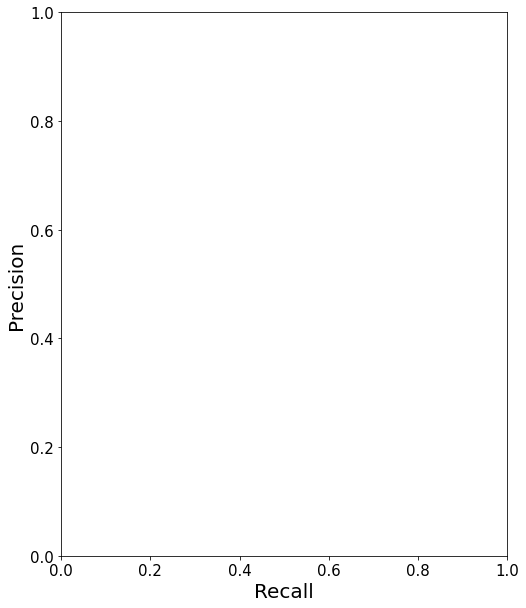

In [147]:
vtype = "INDEL"    
plt.xlabel('Recall')
plt.ylabel('Precision') 
remote_base = "a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_10x/HCC1395_SPP_PURE_10x/SPP_GT_1-0_1/"
#tmp_vd = get_vd_pred_score(remote_base+"/SPP_GT_1-0_1-vardict.vcf.gz")
tmp_rv = get_rv_pred_score("/home/large/haoz/HCC1395_DATAS/SPP/rabbitvar_result/diff_dpeth/som_res_1003_withrfv/SPP_PURE_10x.indel.vcf")
tmp_sk = get_sk2_pred_socre(remote_base+"/SPP_GT_1-0_1-strelka2.vcf.gz")
tmp_mt = get_mt_pred_socre(remote_base+"/SPP_GT_1-0_1-mutect2.vcf.gz")
ROC_DATA_INDEL['10x'] = [tmp_rv, tmp_sk, tmp_mt]
# plot_prec_recall_curve(tmp1, 'RabbitVar')
# plot_prec_recall_curve(tmp2, 'Strelka2')
# plot_prec_recall_curve(tmp_mt2, 'Mutect2')
# #plot_prec_recall_curve(tmp_vd, 'VarDict')
# plt.savefig('10xindel.roc.pdf', format = "PDF")

geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_30x/HCC1395_SPP_PURE_30x/SPP_GT_1-0_1//SPP_GT_1-0_1-strelka2.vcf.gz /dev/shm/tmp.gz
status:  0
geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_30x/HCC1395_SPP_PURE_30x/SPP_GT_1-0_1//SPP_GT_1-0_1-mutect2.vcf.gz /dev/shm/tmp.gz
status:  0


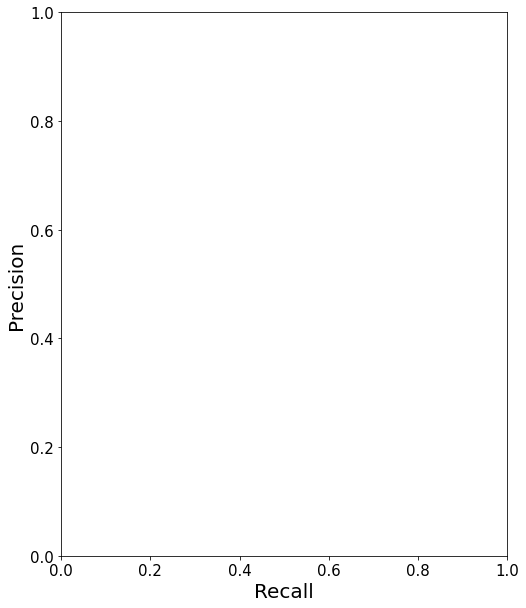

In [148]:
vtype = "INDEL"    
plt.xlabel('Recall')
plt.ylabel('Precision') 
remote_base = "a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_30x/HCC1395_SPP_PURE_30x/SPP_GT_1-0_1/"
#tmp_vd = get_vd_pred_score(remote_base+"/SPP_GT_1-0_1-vardict.vcf.gz")
tmp_rv = get_rv_pred_score("/home/large/haoz/HCC1395_DATAS/SPP/rabbitvar_result/diff_dpeth/som_res_1003_withrfv/SPP_PURE_30x.indel.vcf")
tmp_sk = get_sk2_pred_socre(remote_base+"/SPP_GT_1-0_1-strelka2.vcf.gz")
tmp_mt = get_mt_pred_socre(remote_base+"/SPP_GT_1-0_1-mutect2.vcf.gz")
ROC_DATA_INDEL['30x'] = [tmp_rv, tmp_sk, tmp_mt]
# plot_prec_recall_curve(tmp1, 'RabbitVar')
# plot_prec_recall_curve(tmp2, 'Strelka2')
# plot_prec_recall_curve(tmp_mt2, 'Mutect2')
# #plot_prec_recall_curve(tmp_vd, 'VarDict')

# plt.savefig('30xindel.roc.pdf', format = "PDF")

geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_50x/HCC1395_SPP_PURE_50x/SPP_GT_1-0_1//SPP_GT_1-0_1-strelka2.vcf.gz /dev/shm/tmp.gz
status:  0
geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_50x/HCC1395_SPP_PURE_50x/SPP_GT_1-0_1//SPP_GT_1-0_1-mutect2.vcf.gz /dev/shm/tmp.gz
status:  0


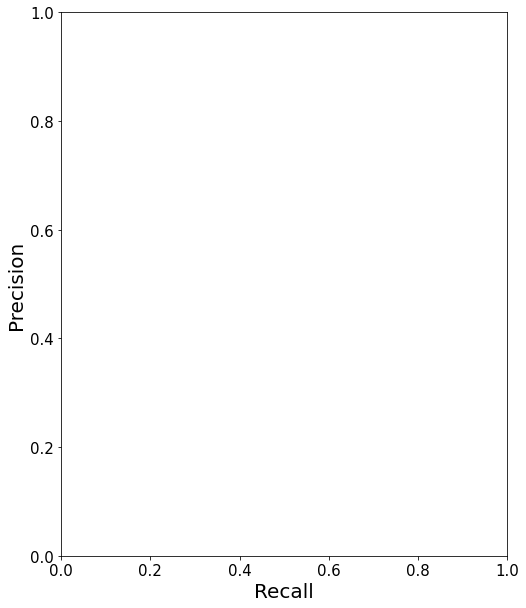

In [149]:
vtype = "INDEL"    
plt.xlabel('Recall')
plt.ylabel('Precision') 
remote_base = "a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_50x/HCC1395_SPP_PURE_50x/SPP_GT_1-0_1/"
# tmp_vd = get_vd_pred_score(remote_base+"/SPP_GT_1-0_1-vardict.vcf.gz")
tmp_rv = get_rv_pred_score("/home/large/haoz/HCC1395_DATAS/SPP/rabbitvar_result/diff_dpeth/som_res_1003_withrfv/SPP_PURE_50x.indel.vcf")
tmp_sk = get_sk2_pred_socre(remote_base+"/SPP_GT_1-0_1-strelka2.vcf.gz")
tmp_mt = get_mt_pred_socre(remote_base+"/SPP_GT_1-0_1-mutect2.vcf.gz")
ROC_DATA_INDEL['50x'] = [tmp_rv, tmp_sk, tmp_mt]
# plot_prec_recall_curve(tmp1, 'RabbitVar')
# plot_prec_recall_curve(tmp2, 'Strelka2')
# plot_prec_recall_curve(tmp_mt2, 'Mutect2')
# # plot_prec_recall_curve(tmp_vd, 'VarDict')

# plt.savefig('50xindel.roc.pdf', format = "PDF")

geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_200x/HCC1395_SPP_PURE_200x/SPP_GT_1-0_200X//SPP_GT_1-0_200X-strelka2.vcf.gz /dev/shm/tmp.gz
status:  0
geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_200x/HCC1395_SPP_PURE_200x/SPP_GT_1-0_200X//SPP_GT_1-0_200X-mutect2.vcf.gz /dev/shm/tmp.gz
status:  0


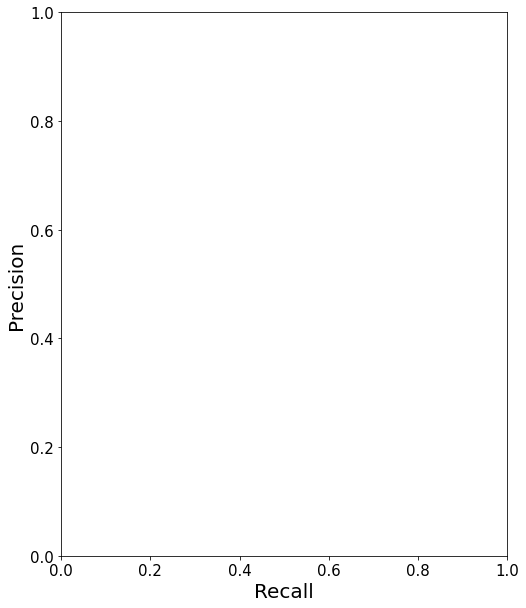

In [150]:
vtype = "INDEL"    
plt.xlabel('Recall')
plt.ylabel('Precision') 
remote_base = "a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_200x/HCC1395_SPP_PURE_200x/SPP_GT_1-0_200X/"
# tmp_vd = get_vd_pred_score(remote_base+"/SPP_GT_1-0_200X-vardict.vcf.gz")
tmp_rv = get_rv_pred_score("/home/large/haoz/HCC1395_DATAS/SPP/rabbitvar_result/diff_dpeth/som_res_1003_withrfv/SPP_PURE_200x.indel.vcf")
tmp_sk = get_sk2_pred_socre(remote_base+"/SPP_GT_1-0_200X-strelka2.vcf.gz")
tmp_mt = get_mt_pred_socre(remote_base+"/SPP_GT_1-0_200X-mutect2.vcf.gz")
ROC_DATA_INDEL['200x'] = [tmp_rv, tmp_sk, tmp_mt]
# plot_prec_recall_curve(tmp1, 'RabbitVar')
# plot_prec_recall_curve(tmp2, 'Strelka2')
# plot_prec_recall_curve(tmp_mt2, 'Mutect2')
# # plot_prec_recall_curve(tmp_vd, 'VarDict')

# plt.savefig('200xindel.roc.pdf', format = "PDF")

geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_300x/HCC1395_SPP_PURE_300x/SPP_GT_1-0_300X//SPP_GT_1-0_300X-strelka2.vcf.gz /dev/shm/tmp.gz
status:  0
geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_300x/HCC1395_SPP_PURE_300x/SPP_GT_1-0_300X//SPP_GT_1-0_300X-mutect2.vcf.gz /dev/shm/tmp.gz
status:  0


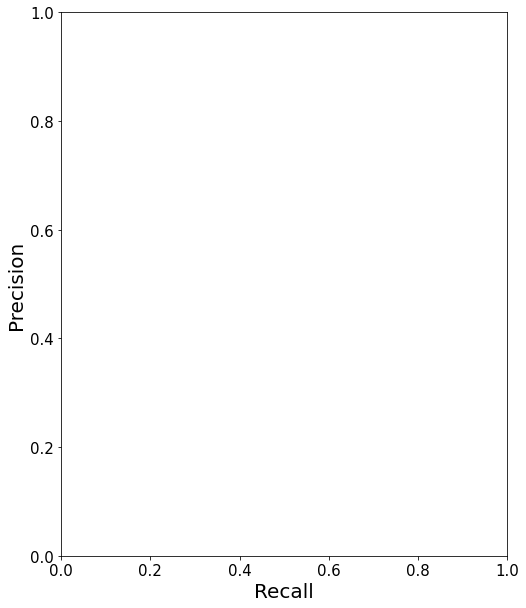

In [151]:
vtype = "INDEL"    
plt.xlabel('Recall')
plt.ylabel('Precision') 
remote_base = "a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_300x/HCC1395_SPP_PURE_300x/SPP_GT_1-0_300X/"
# tmp_vd = get_vd_pred_score(remote_base+"/SPP_GT_1-0_300X-vardict.vcf.gz")
tmp_rv = get_rv_pred_score("/home/large/haoz/HCC1395_DATAS/SPP/rabbitvar_result/diff_dpeth/som_res_1003_withrfv/SPP_PURE_300x.indel.vcf")
tmp_sk = get_sk2_pred_socre(remote_base+"/SPP_GT_1-0_300X-strelka2.vcf.gz")
tmp_mt = get_mt_pred_socre(remote_base+"/SPP_GT_1-0_300X-mutect2.vcf.gz")
ROC_DATA_INDEL['300x'] = [tmp_rv, tmp_sk, tmp_mt]
# plot_prec_recall_curve(tmp1, 'RabbitVar')
# plot_prec_recall_curve(tmp2, 'Strelka2')
# plot_prec_recall_curve(tmp_mt2, 'Mutect2')
# # plot_prec_recall_curve(tmp_vd, 'VarDict')

# plt.savefig('300xindel.roc.pdf', format = "PDF")

## SNV ROC CURVE

In [160]:
vtype = 'INDEL'
truth_file = "/home/user_home/data_share/FD/Truth/sINDEL.MDKT.superSet.v1.2.vcf"
truth_vars_indel = get_truth(truth_file)

vtype = 'SNV'
truth_file = "/home/user_home/data_share/FD/Truth/sSNV.MSDUKT.superSet.v1.2.vcf"
truth_vars_snv = get_truth(truth_file)


In [165]:
vtype = 'SNV'
truth_file = "/home/user_home/data_share/FD/Truth/sSNV.MSDUKT.superSet.v1.2.vcf"
truth_vars = get_truth(truth_file)
print('length of truth vars is:', len(truth_vars))
ROC_DATA_SNV = dict()

# plt.xlabel('Recall')
# plt.ylabel('Precision')    
#tmp_vd = get_vd_pred_score("a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_80x/HCC1395_SPP_PURE_80x/SPP_GT_1-0_1/SPP_GT_1-0_1-vardict.vcf.gz")
tmp1 = get_rv_pred_score("/home/large/haoz/HCC1395_DATAS/SPP/rabbitvar_result/diff_dpeth/som_res_1003_withrfv/SPP_PURE_80x.snv.vcf")
tmp2 = get_sk2_pred_socre("a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_80x/HCC1395_SPP_PURE_80x/SPP_GT_1-0_1/SPP_GT_1-0_1-strelka2.vcf.gz")
tmp_mt2 = get_mt_pred_socre("a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_80x/HCC1395_SPP_PURE_80x/SPP_GT_1-0_1/SPP_GT_1-0_1-mutect2.vcf.gz")
ROC_DATA_SNV['80x'] = [tmp1, tmp2, tmp_mt2]
# plot_prec_recall_curve(tmp1, 'RabbitVar')
# plot_prec_recall_curve(tmp2, 'Strelka2')
# plot_prec_recall_curve(tmp_mt2, 'Mutect2')
# #plot_prec_recall_curve(tmp_vd, 'VarDict')

# plt.savefig('80xsnv_roc.pdf', format = "PDF")

length of truth vars is: 78028
geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_80x/HCC1395_SPP_PURE_80x/SPP_GT_1-0_1/SPP_GT_1-0_1-strelka2.vcf.gz /dev/shm/tmp.gz
status:  0
geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_80x/HCC1395_SPP_PURE_80x/SPP_GT_1-0_1/SPP_GT_1-0_1-mutect2.vcf.gz /dev/shm/tmp.gz
status:  0


In [166]:
vtype = "SNV"    
# plt.xlabel('Recall')
# plt.ylabel('Precision') 
remote_base = "a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_10x/HCC1395_SPP_PURE_10x/SPP_GT_1-0_1/"
#tmp_vd = get_vd_pred_score(remote_base+"/SPP_GT_1-0_1-vardict.vcf.gz")
tmp1 = get_rv_pred_score("/home/large/haoz/HCC1395_DATAS/SPP/rabbitvar_result/diff_dpeth/som_res_1003_withrfv/SPP_PURE_10x.snv.vcf")
tmp2 = get_sk2_pred_socre(remote_base+"/SPP_GT_1-0_1-strelka2.vcf.gz")
tmp_mt2 = get_mt_pred_socre(remote_base+"/SPP_GT_1-0_1-mutect2.vcf.gz")
ROC_DATA_SNV['10x'] = [tmp1, tmp2, tmp_mt2]
# plot_prec_recall_curve(tmp1, 'RabbitVar')
# plot_prec_recall_curve(tmp2, 'Strelka2')
# plot_prec_recall_curve(tmp_mt2, 'Mutect2')
# #plot_prec_recall_curve(tmp_vd, 'VarDict')

# plt.savefig('10xsnv_roc.pdf', format = "PDF")

geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_10x/HCC1395_SPP_PURE_10x/SPP_GT_1-0_1//SPP_GT_1-0_1-strelka2.vcf.gz /dev/shm/tmp.gz
status:  0
geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_10x/HCC1395_SPP_PURE_10x/SPP_GT_1-0_1//SPP_GT_1-0_1-mutect2.vcf.gz /dev/shm/tmp.gz
status:  0


In [167]:
vtype = "SNV"    
# plt.xlabel('Recall')
# plt.ylabel('Precision') 
remote_base = "a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_30x/HCC1395_SPP_PURE_30x/SPP_GT_1-0_1/"
#tmp_vd = get_vd_pred_score(remote_base+"/SPP_GT_1-0_1-vardict.vcf.gz")
tmp1 = get_rv_pred_score("/home/large/haoz/HCC1395_DATAS/SPP/rabbitvar_result/diff_dpeth/som_res_1003_withrfv/SPP_PURE_30x.snv.vcf")
tmp2 = get_sk2_pred_socre(remote_base+"/SPP_GT_1-0_1-strelka2.vcf.gz")
tmp_mt2 = get_mt_pred_socre(remote_base+"/SPP_GT_1-0_1-mutect2.vcf.gz")
ROC_DATA_SNV['30x'] = [tmp1, tmp2, tmp_mt2]
# plot_prec_recall_curve(tmp1, 'RabbitVar')
# plot_prec_recall_curve(tmp2, 'Strelka2')
# plot_prec_recall_curve(tmp_mt2, 'Mutect2')
# #plot_prec_recall_curve(tmp_vd, 'VarDict')

# plt.savefig('30xsnv_roc.pdf', format = "PDF")

geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_30x/HCC1395_SPP_PURE_30x/SPP_GT_1-0_1//SPP_GT_1-0_1-strelka2.vcf.gz /dev/shm/tmp.gz
status:  0
geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_30x/HCC1395_SPP_PURE_30x/SPP_GT_1-0_1//SPP_GT_1-0_1-mutect2.vcf.gz /dev/shm/tmp.gz
status:  0


In [168]:
vtype = "SNV"    
# plt.xlabel('Recall')
# plt.ylabel('Precision') 
remote_base = "a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_50x/HCC1395_SPP_PURE_50x/SPP_GT_1-0_1/"
#tmp_vd = get_vd_pred_score(remote_base+"/SPP_GT_1-0_1-vardict.vcf.gz")
tmp1 = get_rv_pred_score("/home/large/haoz/HCC1395_DATAS/SPP/rabbitvar_result/diff_dpeth/som_res_1003_withrfv/SPP_PURE_50x.snv.vcf")
tmp2 = get_sk2_pred_socre(remote_base+"/SPP_GT_1-0_1-strelka2.vcf.gz")
tmp_mt2 = get_mt_pred_socre(remote_base+"/SPP_GT_1-0_1-mutect2.vcf.gz")
ROC_DATA_SNV['50x'] = [tmp1, tmp2, tmp_mt2]
# plot_prec_recall_curve(tmp1, 'RabbitVar')
# plot_prec_recall_curve(tmp2, 'Strelka2')
# plot_prec_recall_curve(tmp_mt2, 'Mutect2')
# #plot_prec_recall_curve(tmp_vd, 'VarDict')

# plt.savefig('50xsnv_roc.pdf', format = "PDF")

geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_50x/HCC1395_SPP_PURE_50x/SPP_GT_1-0_1//SPP_GT_1-0_1-strelka2.vcf.gz /dev/shm/tmp.gz
status:  0
geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_50x/HCC1395_SPP_PURE_50x/SPP_GT_1-0_1//SPP_GT_1-0_1-mutect2.vcf.gz /dev/shm/tmp.gz
status:  0


In [169]:
vtype = "SNV"    
# plt.xlabel('Recall')
# plt.ylabel('Precision') 
remote_base = "a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_200x/HCC1395_SPP_PURE_200x/SPP_GT_1-0_200X/"
#tmp_vd = get_vd_pred_score(remote_base+"/SPP_GT_1-0_1-vardict.vcf.gz")
tmp1 = get_rv_pred_score("/home/large/haoz/HCC1395_DATAS/SPP/rabbitvar_result/diff_dpeth/som_res_1003_withrfv/SPP_PURE_200x.snv.vcf")
tmp2 = get_sk2_pred_socre(remote_base+"/SPP_GT_1-0_200X-strelka2.vcf.gz")
tmp_mt2 = get_mt_pred_socre(remote_base+"/SPP_GT_1-0_200X-mutect2.vcf.gz")
ROC_DATA_SNV['200x'] = [tmp1, tmp2, tmp_mt2]
# plot_prec_recall_curve(tmp1, 'RabbitVar')
# plot_prec_recall_curve(tmp2, 'Strelka2')
# plot_prec_recall_curve(tmp_mt2, 'Mutect2')
# #plot_prec_recall_curve(tmp_vd, 'VarDict')

# plt.savefig('200xsnv_roc.pdf', format = "PDF")

geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_200x/HCC1395_SPP_PURE_200x/SPP_GT_1-0_200X//SPP_GT_1-0_200X-strelka2.vcf.gz /dev/shm/tmp.gz
status:  0
geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_200x/HCC1395_SPP_PURE_200x/SPP_GT_1-0_200X//SPP_GT_1-0_200X-mutect2.vcf.gz /dev/shm/tmp.gz
status:  0


In [170]:
vtype = "SNV"    
# plt.xlabel('Recall')
# plt.ylabel('Precision') 
remote_base = "a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_300x/HCC1395_SPP_PURE_300x/SPP_GT_1-0_300X/"
#tmp_vd = get_vd_pred_score(remote_base+"/SPP_GT_1-0_1-vardict.vcf.gz")
tmp1 = get_rv_pred_score("/home/large/haoz/HCC1395_DATAS/SPP/rabbitvar_result/diff_dpeth/som_res_1003_withrfv/SPP_PURE_300x.snv.vcf")
tmp2 = get_sk2_pred_socre(remote_base+"/SPP_GT_1-0_300X-strelka2.vcf.gz")
tmp_mt2 = get_mt_pred_socre(remote_base+"/SPP_GT_1-0_300X-mutect2.vcf.gz")
ROC_DATA_SNV['300x'] = [tmp1, tmp2, tmp_mt2]
# plot_prec_recall_curve(tmp1, 'RabbitVar')
# plot_prec_recall_curve(tmp2, 'Strelka2')
# plot_prec_recall_curve(tmp_mt2, 'Mutect2')
# #plot_prec_recall_curve(tmp_vd, 'VarDict')

# plt.savefig('300xsnv_roc.pdf', format = "PDF")

geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_300x/HCC1395_SPP_PURE_300x/SPP_GT_1-0_300X//SPP_GT_1-0_300X-strelka2.vcf.gz /dev/shm/tmp.gz
status:  0
geting remote file scp a1:/home/large/haoz/BCBIO_SPP_DEPTH_WITH_REGION/workspace/SPP_PURE_300x/HCC1395_SPP_PURE_300x/SPP_GT_1-0_300X//SPP_GT_1-0_300X-mutect2.vcf.gz /dev/shm/tmp.gz
status:  0


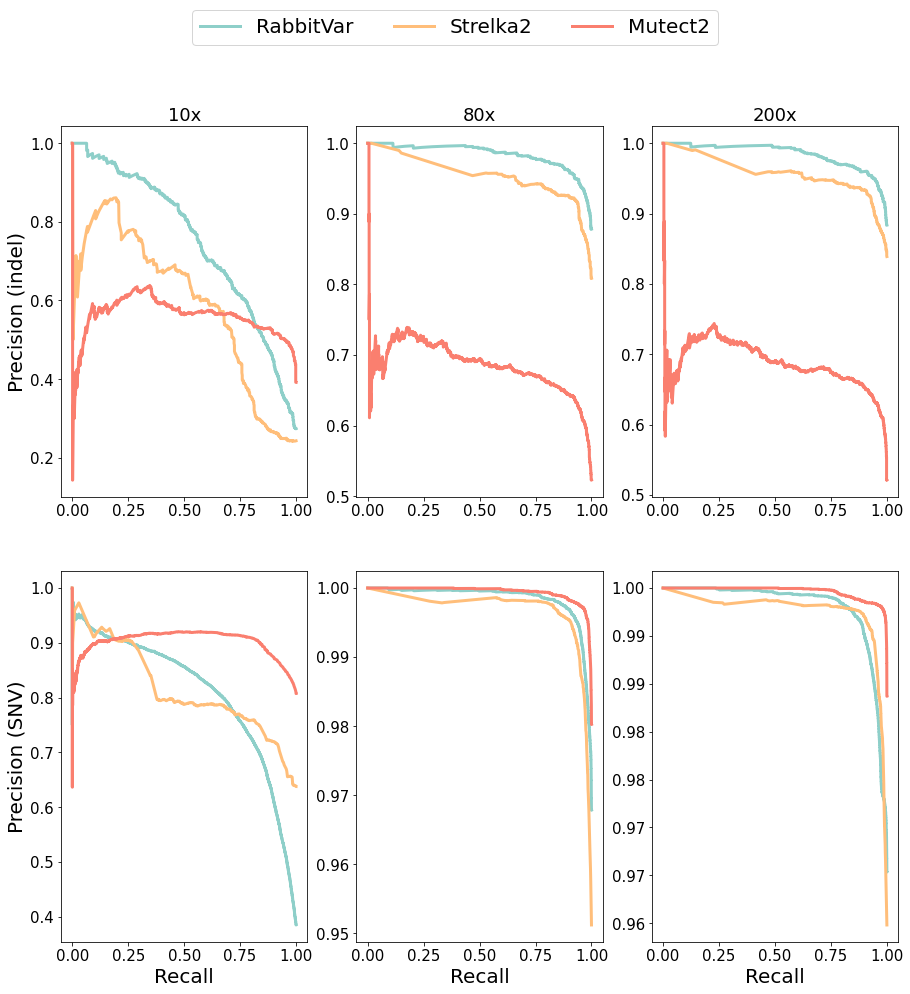

In [196]:
#--------plt an merged data

fig, ([ax11, ax12, ax13], [ax21, ax22, ax23]) = plt.subplots(2, 3, figsize=(15, 15))
def ax_plot_prec_recall_curve(ax, DATA, truth_vars):
  for index, label in enumerate(['RabbitVar', 'Strelka2', 'Mutect2']):
    tmp = DATA[index]
    data = pd.DataFrame()
    data['site'] = tmp.keys()
    data['pred'] = tmp.values()
    data['truth'] = data.apply(rabv_get_label, axis = 1, args = (truth_vars,))
    precision, recall, thresholds = precision_recall_curve(data['truth'], data['pred'])
    ax.plot(recall, precision, label = label, color = g_color_map[label], linewidth = 3)  
    if g_add_legend:
      plt.legend()
ax11.set_ylabel("Precision (indel)")  
ax11.set_title('10x', fontsize = 18)
ax_plot_prec_recall_curve(ax11, ROC_DATA_INDEL['10x'], truth_vars_indel) 
ax12.set_title('80x', fontsize = 18)
ax_plot_prec_recall_curve(ax12, ROC_DATA_INDEL['80x'], truth_vars_indel)
ax13.set_title('200x', fontsize = 18)
ax_plot_prec_recall_curve(ax13, ROC_DATA_INDEL['200x'], truth_vars_indel) 
ax21.set_ylabel("Precision (SNV)")
ax21.set_xlabel("Recall")
ax_plot_prec_recall_curve(ax21, ROC_DATA_SNV['10x'], truth_vars_snv) 
ax22.set_xlabel("Recall")
ax_plot_prec_recall_curve(ax22, ROC_DATA_SNV['80x'], truth_vars_snv)

import matplotlib.ticker as mtike
ax23.yaxis.set_major_formatter(mtike.FormatStrFormatter('%.2f'))
ax23.set_xlabel("Recall")
ax_plot_prec_recall_curve(ax23, ROC_DATA_SNV['200x'], truth_vars_snv)


lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# Finally, we invoke the legend (that you probably would like to customize...)

fig.legend(lines[:3], labels[:3], fontsize=20,  loc = 'upper center', ncol=3)
plt.savefig('diff_depth_roc_combine.pdf', format='PDF')

In [192]:
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
print(lines)
print(labels)

[<matplotlib.lines.Line2D object at 0x7f8fdbe08fd0>, <matplotlib.lines.Line2D object at 0x7f8fdbd093d0>, <matplotlib.lines.Line2D object at 0x7f8fdbd09310>, <matplotlib.lines.Line2D object at 0x7f8fdbd099a0>, <matplotlib.lines.Line2D object at 0x7f8fdbd09820>, <matplotlib.lines.Line2D object at 0x7f8fdbd3a040>, <matplotlib.lines.Line2D object at 0x7f8fdbd3a370>, <matplotlib.lines.Line2D object at 0x7f8fdbd3a1f0>, <matplotlib.lines.Line2D object at 0x7f8fdbd3a670>, <matplotlib.lines.Line2D object at 0x7f8fdbd3ad00>, <matplotlib.lines.Line2D object at 0x7f8fdbd12070>, <matplotlib.lines.Line2D object at 0x7f8fdbd12040>, <matplotlib.lines.Line2D object at 0x7f8fdbd126d0>, <matplotlib.lines.Line2D object at 0x7f8fdbd12370>, <matplotlib.lines.Line2D object at 0x7f8fdbd129d0>, <matplotlib.lines.Line2D object at 0x7f8fdbccc0d0>, <matplotlib.lines.Line2D object at 0x7f8fdbccc490>, <matplotlib.lines.Line2D object at 0x7f8fdbccc3d0>]
['RabbitVar', 'Strelka2', 'Mutect2', 'RabbitVar', 'Strelka2', '

# Different Depth SPP1395

Index(['Depth', 'strelka', 'mutect', 'vardict', 'rabbitvar'], dtype='object')
             Depth  rabbitvar  strelka  mutect  vardict
0   SPP_PURE_10x         10.0      8.0    45.0     52.0
1   SPP_PURE_30x         13.0     14.0    57.0    158.0
2   SPP_PURE_50x         16.0     17.0    76.0    259.0
3   SPP_PURE_80x         21.0     26.0   110.0    362.0
4   SPP_PURE_200x        43.0     64.0   306.0    781.0
5   SPP_PURE_300x        61.0     96.0   512.0   1051.0


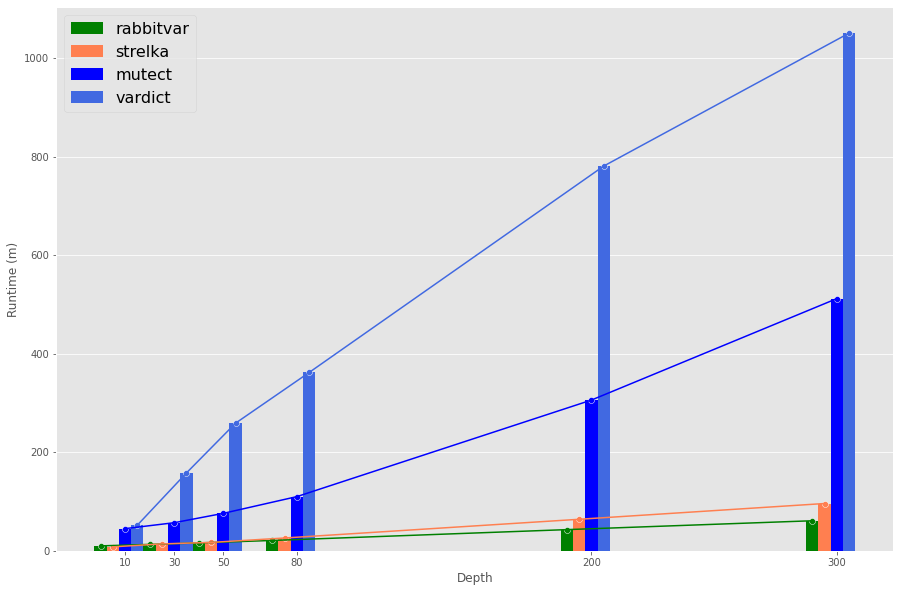

In [1]:
import pandas as pd
from numpy import *
import re
from io import StringIO
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

def get_time_s(t):
    #print(t)
    res = 0
    if t.find('m') != -1: #xxmxxs
        m,s = t.split('m')[:2]
        res += int(m) * 60
        if s == '': 
            return res
        else:
            t = s
    if t[-1] == 's':
        res += float(t[:-1])
    return res

def get_time_m(t):
  return get_time_s(t) / 60

def pd_read_from_org(fname):
  buf = ""
  with open(filename, 'r') as f:
    for line in f:
      if line[0] != "|": continue;
      if not re.match("^\|-[-\+]+\|$", line):  # skip spilt line |-----+-----+----|
        buf += line

  D = pd.read_csv(StringIO(buf), sep='|')
  D = D.drop(D.columns[0], axis=1)
  D = D.drop(D.columns[-1], axis=1)
  D = D.rename(columns=lambda x: x.strip())
  return D
filename = "runtime_depth.org"
data = pd_read_from_org(filename)
print(data.columns)
for c in ['strelka', 'mutect', 'vardict', 'rabbitvar']:
  data[c] = data[c].map(get_time_m)
data = data[['Depth', 'rabbitvar', 'strelka', 'mutect', 'vardict']]
print(data)

#data['caller'] = data.apply(lambda x: x['caller & data'].split('_')[-1], axis = 1)
#data['data'] =  data.apply(lambda x: '_'.join(x['caller & data'].split('_')[:-1]), axis = 1)
#print(data)
plt.figure(figsize=(15, 10))
plt.style.use('ggplot')
plt.grid(axis="x")
plt.xlabel("Depth")
plt.ylabel("Runtime (m)")
plt.xticks([10, 30, 50, 80, 200, 300])
colors = ['green', 'coral', 'blue', 'royalblue']

i = -10
for caller in data.columns[1:]:
  #plt.title("Depth to runtime evaluation", fontsize=18,)
  cc = colors[(i+10) // 5]
  x_bar = [10+i, 30+i, 50+i, 80+i, 200+i, 300+i]
  bfg = plt.bar(x = x_bar, height = data[caller], label = caller, width = 5, color = cc)
  gfg = sns.lineplot(x = x_bar, y = data[caller],  color = cc)
  cfg = sns.scatterplot(x = x_bar, y = data[caller], color = cc)
  i += 5
#data[data.columns[1:]].plot(kind = 'bar')
#data[data.columns[1:]].plot(kind = 'line', secondary_y=True)
plt.legend(prop={'size': 16})
plt.savefig("./depth_runtime.pdf")

# Purity

In [198]:
def put_purity_data(rv_path, other_path, DATA_DICT, Key):
  tmp_vd = get_vd_pred_score(remote_base+"/SPP_GT_1-0_1-vardict.vcf.gz")
  tmp_rv = get_rv_pred_score(rv_path)
  tmp_sk = get_sk2_pred_socre(remote_base+"/SPP_GT_1-0_1-strelka2.vcf.gz")
  tmp_mt = get_mt_pred_socre(remote_base+"/SPP_GT_1-0_1-mutect2.vcf.gz")
  ROC_DATA_SNV[Key] = [tmp_rv, tmp_sk, tmp_mt, tmp_vd]

In [199]:
P2_WK = "p2:/home/user_home/haoz/data/BCBIO_SPP_HIGHCONF/workspace"
KEY_PATH_MAP={
  'T100N100_1': P2_WK + "/SPP_GT_1-0_1_AND_SPP_GT_0-1_1/HCC1395_SPP_GT_1-0_1_AND_SPP_GT_0-1_1/SPP_GT_1-0_1",
  'T100N100_2': P2_WK + "/SPP_GT_1-0_2_AND_SPP_GT_0-1_2/HCC1395_SPP_GT_1-0_2_AND_SPP_GT_0-1_2/SPP_GT_1-0_2",
  'T100N100_3': P2_WK + "/SPP_GT_1-0_3_AND_SPP_GT_0-1_3/HCC1395_SPP_GT_1-0_3_AND_SPP_GT_0-1_3/SPP_GT_1-0_3",
  'T75N100_1' : P2_WK + "/SPP_GT_3-1_1_AND_SPP_GT_0-1_1/HCC1395_SPP_GT_3-1_1_AND_SPP_GT_0-1_1/SPP_GT_3-1_1",
  'T75N100_2' : P2_WK + "/SPP_GT_3-1_2_AND_SPP_GT_0-1_2/HCC1395_SPP_GT_3-1_2_AND_SPP_GT_0-1_2/SPP_GT_3-1_2",
  'T75N100_3' : P2_WK + "/SPP_GT_3-1_3_AND_SPP_GT_0-1_3/HCC1395_SPP_GT_3-1_3_AND_SPP_GT_0-1_3/SPP_GT_3-1_3",
}

In [203]:
vtype = "INDEL"
PURITY_DATA_DICT_SNV = {}
for key, remote_base in KEY_PATH_MAP.items():
  label = remote_base.split("/")[-3] + "_" + vtype + ".vcf" #label: like SPP_GT_1-0_1_AND_SPP_GT_0-1_1 | key: like T100N100_1
  #remote_base = KEY_PATH_MAP[key]
  rvpath = "/home/large/haoz/HCC1395_DATAS/SPP/rabbitvar_result/som_res_0920/" + label
  print(rvpath)
  continue
  put_purity_data(rvpath, remote_base, PURITY_DATA_DICT_SNV, key)

/home/large/haoz/HCC1395_DATAS/SPP/rabbitvar_result/som_res_0920/SPP_GT_1-0_1_AND_SPP_GT_0-1_1_INDEL.vcf
/home/large/haoz/HCC1395_DATAS/SPP/rabbitvar_result/som_res_0920/SPP_GT_1-0_2_AND_SPP_GT_0-1_2_INDEL.vcf
/home/large/haoz/HCC1395_DATAS/SPP/rabbitvar_result/som_res_0920/SPP_GT_1-0_3_AND_SPP_GT_0-1_3_INDEL.vcf
/home/large/haoz/HCC1395_DATAS/SPP/rabbitvar_result/som_res_0920/SPP_GT_3-1_1_AND_SPP_GT_0-1_1_INDEL.vcf
/home/large/haoz/HCC1395_DATAS/SPP/rabbitvar_result/som_res_0920/SPP_GT_3-1_2_AND_SPP_GT_0-1_2_INDEL.vcf
/home/large/haoz/HCC1395_DATAS/SPP/rabbitvar_result/som_res_0920/SPP_GT_3-1_3_AND_SPP_GT_0-1_3_INDEL.vcf
